## Introduction

**About this Project**

This project is meant to visual the premium of stock options versus their strike price. Currently, I only look at how the premium of out-of-the-money decays in 2 ways:

    - you move the strike price away from the current stock price
    - you move the expiration date closer to the current date

I visualize these premiums using plots and animations. If you are not familiar with stock options, I recommend watching a quick intro on them on YouTube before going further.

**Data**

I used the EOD Historical Data api: https://eodhistoricaldata.com/financial-apis/stock-options-data/

data['data'] -> list with options data for all expiration dates<br>
data['data'][0]['options'] -> all call/put options for first expiration date<br>
data['data'][0]['options']['CALL'] -> all call options data for first expiration date<br>
data['data'][0]['options']['CALL'][0] -> first call option data for first expiration date<br>

Example Option Data for data['data'][0]['options']['CALL'][0]:

{'contractName': 'AAPL201231C00085000', 'contractSize': 'REGULAR', 'currency': 'USD', 'type': 'CALL', 'inTheMoney': 'TRUE', 'lastTradeDateTime': '2020-12-23 10:32:03', 'expirationDate': '2020-12-31', 'strike': 85, 'lastPrice': 46.55, 'bid': 46.85, 'ask': 47.15, 'change': 5.2, 'changePercent': 0.1258, 'volume': 39, 'openInterest': 182, 'impliedVolatility': 100.0435, 'delta': 0.9994, 'gamma': 0.0001, 'theta': -0.0065, 'vega': 0.0004, 'rho': 0.0163, 'theoretical': 47, 'intrinsicValue': 0, 'timeValue': 0, 'updatedAt': '2020-12-24 19:16:06', 'daysBeforeExpiration': 6}

## Imports

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
from IPython import display

In [2]:
from secrets import EOD_HISTORICAL_DATA_API_TOKEN

## Functions

**Function: createDatesStringArray**<br>

Creates a string array of dates with given start date, difference between them (default: 1 week), and the size of
the array. The start date is inclusive

In [3]:
def createDatesStringArray(startDate = datetime.date.today(), deltaDays = 7, N = 5):
    nextDate = startDate
    datesStringArray = []
    for i in range(N):
        datesStringArray.append(str(nextDate))
        tdelta = datetime.timedelta(days=deltaDays)
        nextDate = nextDate + tdelta
    return(datesStringArray)

**Function: calculateIntrinsicValueAndBreakEven**<br>

Function that calculates the intrinsic value and breakeven of a given option and a given current stock price

In [4]:
def calculateIntrinsicValueAndBreakEven(option, lastTradePrice):
    if(option['type'] == 'PUT' or option['type'] == 'put'):
        multiplier = -1
    else:
        multiplier = 1
    
    intrinsicValue = multiplier * (lastTradePrice - option['strike'])
    if(intrinsicValue < 0):
        intrinsicValue = 0

    breakeven = option['strike'] + multiplier*option['lastPrice']
    
    return intrinsicValue, breakeven

**Function: animationFrame**

This function is used by FuncAnimation to update the frame

In [5]:
def animate(frame):

    callsCurve.set_data(callStrikeArrays[len(callStrikeArrays)-1-frame], callLastPriceArrays[len(callLastPriceArrays)-1-frame])
    callsCurve.set_label('Call')
    putsCurve.set_data(putStrikeArrays[len(putStrikeArrays)-1-frame], putLastPriceArrays[len(putLastPriceArrays)-1-frame])
    putsCurve.set_label('Put')

    ax.set_title(f'{symbol} Options Premium Decay - Expiration: {datesArray[len(callStrikeArrays)-1-frame]}')
    ax.legend()
    
    return callsCurve, putsCurve

## Pandas Dataframe/API Call(s)

Create a pandas dataframe, make the API call(s) and store the data in the dataframe so that we can avoid making the api call multiple times, reduce cost, and increase maintainability etc. If the API call changes, we should only have to change it once

In [6]:
# List of Expiration dates to loop over
expirationDates = createDatesStringArray(datetime.date(2021, 1, 22), 7, 20)

# Ticker symbol
symbol = 'AAPL.US'

# Max percent of variation up/down that we want to look at
maxVariation = 0.25


# Create the data frame
options_dataframe_columns = ['Type', 'Expiration', 'Strike', 'Last Price', 'Intrinsic Value', 'Breakeven']
options_dataframe = pd.DataFrame(columns = options_dataframe_columns)

# Loop over all expiration dates and append the data to the dataframe
for date in expirationDates:

    # Make the API call
    api_base_url = 'https://eodhistoricaldata.com/api/'
    api_endpoint_url = f'options/{symbol}/'
    api_token_url = f'?api_token={EOD_HISTORICAL_DATA_API_TOKEN}'
    api_optional_url = f'&from={date}&to={date}'

    api_url = api_base_url + api_endpoint_url + api_token_url + api_optional_url

    data = requests.get(api_url).json()

    # Check if there is any data for that symbol and expiration date
    if data['data'] != []:

        optionsDataCALL = data['data'][0]['options']['CALL']
        optionsDataPUT = data['data'][0]['options']['PUT']
        
        optionsData = optionsDataCALL + optionsDataPUT

        # For each Call/Put option, append its data to the pandas dataframe
        for option in optionsData:
            if(not(option['lastPrice'] is None)):
                
                intrinsicValue, breakeven = calculateIntrinsicValueAndBreakEven(option, data['lastTradePrice'])
                
                options_dataframe = options_dataframe.append(
                    pd.Series(
                        [
                            option['type'],
                            date,
                            option['strike'],
                            option['lastPrice'],
                            intrinsicValue,
                            breakeven
                        ],
                        index = options_dataframe_columns
                    ),
                    ignore_index = True
                )

# Filter out extreme strikes (outside max variation range)
options_dataframe = options_dataframe.loc[abs(options_dataframe['Strike']-data['lastTradePrice'])/data['lastTradePrice'] <= maxVariation]

# Disable the warnings for the next line
pd.options.mode.chained_assignment = None  # default='warn'

# Create a new column with the number of days until expiration
options_dataframe['Num Days'] = (pd.to_datetime(options_dataframe['Expiration'], format='%Y-%m-%d').dt.date - pd.datetime.now().date()).astype('timedelta64[D]').astype('int')

# Out of the money call options grouped by expiration date
options_dataframe_call = options_dataframe.loc[(options_dataframe['Type'] == 'CALL') & (options_dataframe['Intrinsic Value'] == 0)]
options_dataframe_call_byExpiration = options_dataframe_call.groupby(by='Expiration')

# Out of the money put options grouped by expiration date
options_dataframe_put = options_dataframe.loc[(options_dataframe['Type'] == 'PUT') & (options_dataframe['Intrinsic Value'] == 0)]
options_dataframe_put_byExpiration = options_dataframe_put.groupby(by='Expiration')

## Main Run

**Part 1**

Plot all expirations and strikes for comparison

Text(0.5, 1.0, 'AAPL.US Options Strike vs Premium')

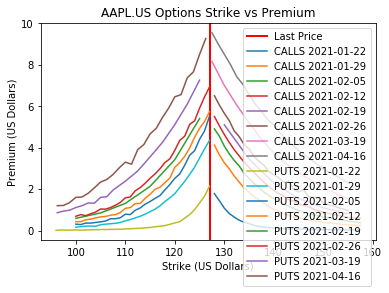

In [7]:
%matplotlib inline

# Create the plot
fig1, ax1 = plt.subplots()

# Add the current price to the plot
ax1.axvline(x=data['lastTradePrice'], label='Last Price', linewidth=2, color='r')

# Add the calls data to the plot
for expiration, frame in options_dataframe_call_byExpiration:
    ax1.plot(frame['Strike'], frame['Last Price'], label='CALLS '+str(expiration))
    
# Add the puts data to the plot
for expiration, frame in options_dataframe_put_byExpiration:
    ax1.plot(frame['Strike'], frame['Last Price'], label='PUTS '+str(expiration))

# Add the labels, legend, and title to the plot
ax1.set_xlabel('Strike (US Dollars)')
ax1.set_ylabel('Premium (US Dollars)')
ax1.legend()
ax1.set_title(str(symbol) + ' Options Strike vs Premium')

**Part 2**

Animate how the premium changes as the expiration date increases

In [8]:
%matplotlib tk

# Create the plots
fig, ax = plt.subplots()

# Initialize the plots with empty data
callsCurves = ax.plot([0], [0])
callsCurve = callsCurves[0]
putsCurves = ax.plot([0], [0])
putsCurve = putsCurves[0]

# Labels
ax.set_xlabel('Strike (US Dollars)')
ax.set_ylabel('Premium (US Dollars)')

# Add the current price to the plot
ax.axvline(x=data['lastTradePrice'], label='Last Price', linewidth=2, color='r')

# Arrays to store all the strikes and last prices for all expirations
callStrikeArrays = []
callLastPriceArrays = []
putStrikeArrays = []
putLastPriceArrays = []
datesArray = []


# Add the calls data and expiration dates to the arrays
for expiration, frame in options_dataframe_call_byExpiration:
    callStrikeArrays.append(frame['Strike'])
    callLastPriceArrays.append(frame['Last Price'])
    datesArray.append(str(expiration))
    
# Add the puts data to the arrays
for expiration, frame in options_dataframe_put_byExpiration:
    putStrikeArrays.append(frame['Strike'])
    putLastPriceArrays.append(frame['Last Price'])
    

# Dynamically set x/y limits for the animated plot
ax.set_xlim(np.min(putStrikeArrays[0]), np.max(callStrikeArrays[len(callStrikeArrays)-1]))
ax.set_ylim(np.min(callLastPriceArrays[0]), np.max(callLastPriceArrays[len(callLastPriceArrays)-1])*1.2)

# Create animation
animation = FuncAnimation(fig, func=animate, frames=len(callStrikeArrays), interval=100)
video = animation.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

**Part 3**

Check how the premium increases as the time (number of weeks) is increased.

In [9]:
# Function that rounds to the given base
def myround(x, base=5):
    return base * round(x/base)

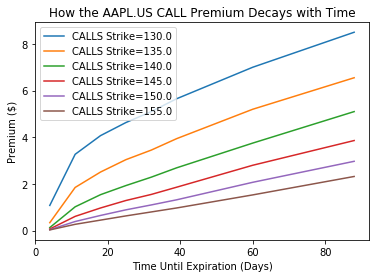

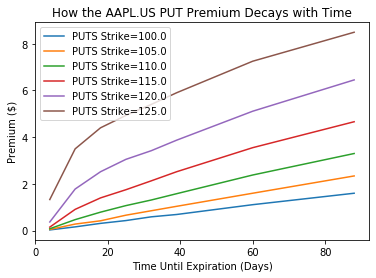

In [10]:
%matplotlib inline

# Call/Put options grouped by strike price
options_dataframe_call_byStrike = options_dataframe_call.groupby(by='Strike')
options_dataframe_put_byStrike = options_dataframe_put.groupby(by='Strike')

# Create the plot/labels/title, etc
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Time Until Expiration (Days)')
ax1.set_ylabel('Premium ($)')
ax1.set_title(f'How the {symbol} CALL Premium Decays with Time')

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Time Until Expiration (Days)')
ax2.set_ylabel('Premium ($)')
ax2.set_title(f'How the {symbol} PUT Premium Decays with Time')

# Array of strike prices to plot (Based on the actual strikes in the dataframe)
strikePriceArray = list(range(myround(np.min(options_dataframe_put['Strike'])), myround(np.max(options_dataframe_call['Strike'])), 5))

# Calls plot
for strike, frame in options_dataframe_call_byStrike:
    if strike in strikePriceArray:
        ax1.plot(frame['Num Days'], frame['Last Price'], label='CALLS Strike='+str(strike))

# Puts plot
for strike, frame in options_dataframe_put_byStrike:
    if strike in strikePriceArray:
        ax2.plot(frame['Num Days'], frame['Last Price'], label='PUTS Strike='+str(strike))

# Add the legends
ax1.legend()
ax2.legend()

**Part 4**

Next look at only the premium minus the intrinsic value

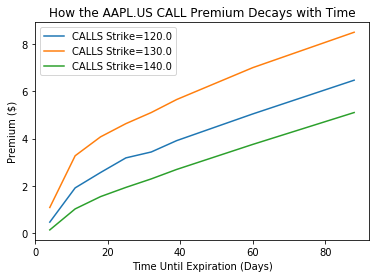

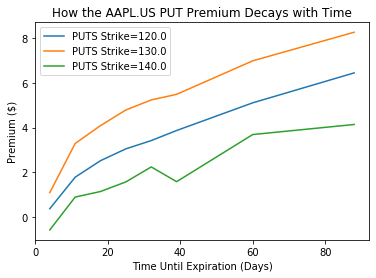

In [11]:
%matplotlib inline

# Call options that are both in and out of the money
options_dataframe_all_call = options_dataframe.loc[options_dataframe['Type'] == 'CALL']

# Put options that are both in and out of the money
options_dataframe_all_put = options_dataframe.loc[options_dataframe['Type'] == 'PUT']

# Call/Put options grouped by strike price
options_dataframe_all_call_byStrike = options_dataframe_all_call.groupby(by='Strike')
options_dataframe_all_put_byStrike = options_dataframe_all_put.groupby(by='Strike')

# Create the plot/labels/title, etc
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Time Until Expiration (Days)')
ax1.set_ylabel('Premium ($)')
ax1.set_title(f'How the {symbol} CALL Premium Decays with Time')

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Time Until Expiration (Days)')
ax2.set_ylabel('Premium ($)')
ax2.set_title(f'How the {symbol} PUT Premium Decays with Time')

# Can't look at all strikes when dealing with in-the-money options as well (it gets messy), so handpicking 3
strikePriceArray = [120, 130, 140]

# Calls plot
for strike, frame in options_dataframe_all_call_byStrike:
    if strike in strikePriceArray:
        ax1.plot(frame['Num Days'], frame['Last Price']-frame['Intrinsic Value'], label='CALLS Strike='+str(strike))

# Puts plot
for strike, frame in options_dataframe_all_put_byStrike:
    if strike in strikePriceArray:
        ax2.plot(frame['Num Days'], frame['Last Price']-frame['Intrinsic Value'], label='PUTS Strike='+str(strike))

# Add the legends
ax1.legend()
ax2.legend()

The highest non-intrinsic premium is (as expected by intuition) on the strike closest to the current stock price.

**Part 5**

Finally, look at the breakeven

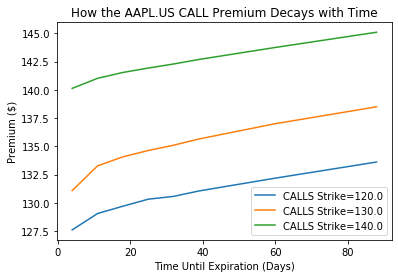

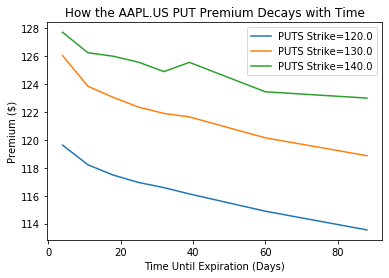

In [12]:
%matplotlib inline

# Call options that are both in and out of the money
options_dataframe_all_call = options_dataframe.loc[options_dataframe['Type'] == 'CALL']

# Put options that are both in and out of the money
options_dataframe_all_put = options_dataframe.loc[options_dataframe['Type'] == 'PUT']

# Call/Put options grouped by strike price
options_dataframe_all_call_byStrike = options_dataframe_all_call.groupby(by='Strike')
options_dataframe_all_put_byStrike = options_dataframe_all_put.groupby(by='Strike')

# Create the plot/labels/title, etc
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Time Until Expiration (Days)')
ax1.set_ylabel('Premium ($)')
ax1.set_title(f'How the {symbol} CALL Premium Decays with Time')

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Time Until Expiration (Days)')
ax2.set_ylabel('Premium ($)')
ax2.set_title(f'How the {symbol} PUT Premium Decays with Time')

# Can't look at all strikes when dealing with in-the-money options as well (it gets messy), so handpicking 3
strikePriceArray = [120, 130, 140]

# Calls plot
for strike, frame in options_dataframe_all_call_byStrike:
    if strike in strikePriceArray:
        ax1.plot(frame['Num Days'], frame['Breakeven'], label='CALLS Strike='+str(strike))

# Puts plot
for strike, frame in options_dataframe_all_put_byStrike:
    if strike in strikePriceArray:
        ax2.plot(frame['Num Days'], frame['Breakeven'], label='PUTS Strike='+str(strike))

# Add the legends
ax1.legend()
ax2.legend()